<table width=100%>
<tr>
    <td><h1 style="text-align: left; font-size:300%;">
        Forest Fires
    </h1></td>
    <td width="20%">
    <div style="text-align: right">
    <b> Machine Learning 2022</b> <br>
    <b>Homework #1  <br>
    <b>Date: 11/05/2022 <br>
    Manenti Carlo - 08389A <br>
    <a href="mailto:carlo.manenti@mail.polimi.it">carlo.manenti@mail.polimi.it</a><br>
    </div>
    </td>
</tr>
</table>

This project focus on understanding the relashionship between variables through the use of feature selection for regression task on a complex data set, the [Forest Fires Data set](https://archive.ics.uci.edu/ml/datasets/forest+fires).

The Forest Fires Data set is composed of 517 observations for 13 variables.     
Variables are mainly meteorological (rain, wind, ecc…)  but some are relate to time (month, days) or spatial data (X, Y grid coordinates of the park). 

## Importing packages

First of all we need to import a few packages that are key to manipulate the data and 
to perform machine learning techniques.

In [1]:
import pandas as pd
import numpy as np 
import seaborn as sns
import matplotlib.pyplot as plt 
import sklearn

## Exploration of the data set
Now we can load and visualize the dataset. It is always best to take a look at the data before performing any
analysis.    
This way we can see if some pre-processing of the data is needed. 

Acronyms: Fine Fuel Moisture Code (FFMC), Duff Moisture Code (DMC), Drought Code (DC), Initial Spread Index (ISI).

In [2]:
ForestFires_data = pd.read_csv("forestfires.csv") 
ForestFires_data.head(10) 

,X,Y,month,day,FFMC,DMC,DC,ISI,temp,RH,wind,rain,area
0,7,5,mar,fri,86.2,26.2,94.3,5.1,8.2,51,6.7,0.0,0.0
1,7,4,oct,tue,90.6,35.4,669.1,6.7,18,33,0.9,0.0,0.0
2,7,4,oct,sat,90.6,43.7,686.9,6.7,14.6,33,1.3,0.0,0.0
3,8,6,mar,fri,91.7,33.3,77.5,9,8.3,97,4,0.2,0.0
4,8,6,mar,sun,89.3,51.3,102.2,9.6,11.4,99,1.8,0.0,0.0
5,8,6,aug,sun,92.3,85.3,488,Missing,22.2,29,5.4,0.0,0.0
6,8,6,aug,mon,92.3,88.9,495.6,8.5,24.1,27,3.1,0.0,0.0
7,8,6,aug,mon,91.5,145.4,608.2,10.7,8,86,2.2,0.0,0.0
8,8,6,sep,tue,91,129.5,692.6,7,13.1,63,5.4,0.0,0.0
9,7,5,sep,sat,92.5,88.0,698.6,7.1,22.8,40,4,0.0,0.0


### Removing missing values
Just by looking at the first few observation in the data set we can spot missing values (line 5, ISI).    
We can define a function to locate missing values: ```MissingValues``` 

In [3]:
def MissingValues(data, x = 'Missing'):   # we must check for 'Missing', NA would not be recognized
    missing_values = (data == x).sum()     # total number of Missing values for each variable
    if missing_values.sum() == 0: 
        print('Total number of missing values:{}'.format(missing_values.sum()))
    else: 
        print(missing_values)
        print('Total number of missing values:{}'.format(missing_values.sum()))
        
MissingValues(ForestFires_data)

X        0
Y        0
month    0
day      0
FFMC     1
DMC      0
DC       1
ISI      2
temp     2
RH       0
wind     1
rain     0
area     0
dtype: int64
Total number of missing values:7


Since there are few missing values (just 7) we can remove rows containing at least one of them to obtain a more consistent data set.   

Another possibility is to guess a reasonable value for each particular missing value.        
This is preferable in the case of a high number of missing values, because it will prevent the removal of many observations. 

In [4]:
# removing rows with at least one missing values

for columns in ForestFires_data.columns:
     ForestFires_data = ForestFires_data[ForestFires_data[columns] != 'Missing']
       
    
MissingValues(ForestFires_data) 

Total number of missing values:0


### Changing the types of the data 
Before visualizing the data we should check the type of the variables. 

In [5]:
ForestFires_data.dtypes

X          int64
Y          int64
month     object
day       object
FFMC      object
DMC      float64
DC        object
ISI       object
temp      object
RH         int64
wind      object
rain     float64
area     float64
dtype: object

Month and days being categorical variables should be handled through the use of dummy variables (more on that later). For all the other variables we prefer them to be of type float64 or int64 to plot them. 
So we can cast a variable to float64 only if is not categorical. 

In [6]:
chategorical_features = ['month', 'day']

for elem in ForestFires_data.columns:
    if elem in chategorical_features :
        pass
    else: 
        ForestFires_data[elem] = ForestFires_data[elem].astype(np.float64)

ForestFires_data.dtypes


X        float64
Y        float64
month     object
day       object
FFMC     float64
DMC      float64
DC       float64
ISI      float64
temp     float64
RH       float64
wind     float64
rain     float64
area     float64
dtype: object

## Visualize the data 
We can easily visualize the data set using ``` SNS.pairplot ```, which plot all the possible combination of 2 variables of the data set. This way we can look at possible relationships between variables and also look at the distribution of the data for single variable using the histograms on the diagonal of the pair plot. 

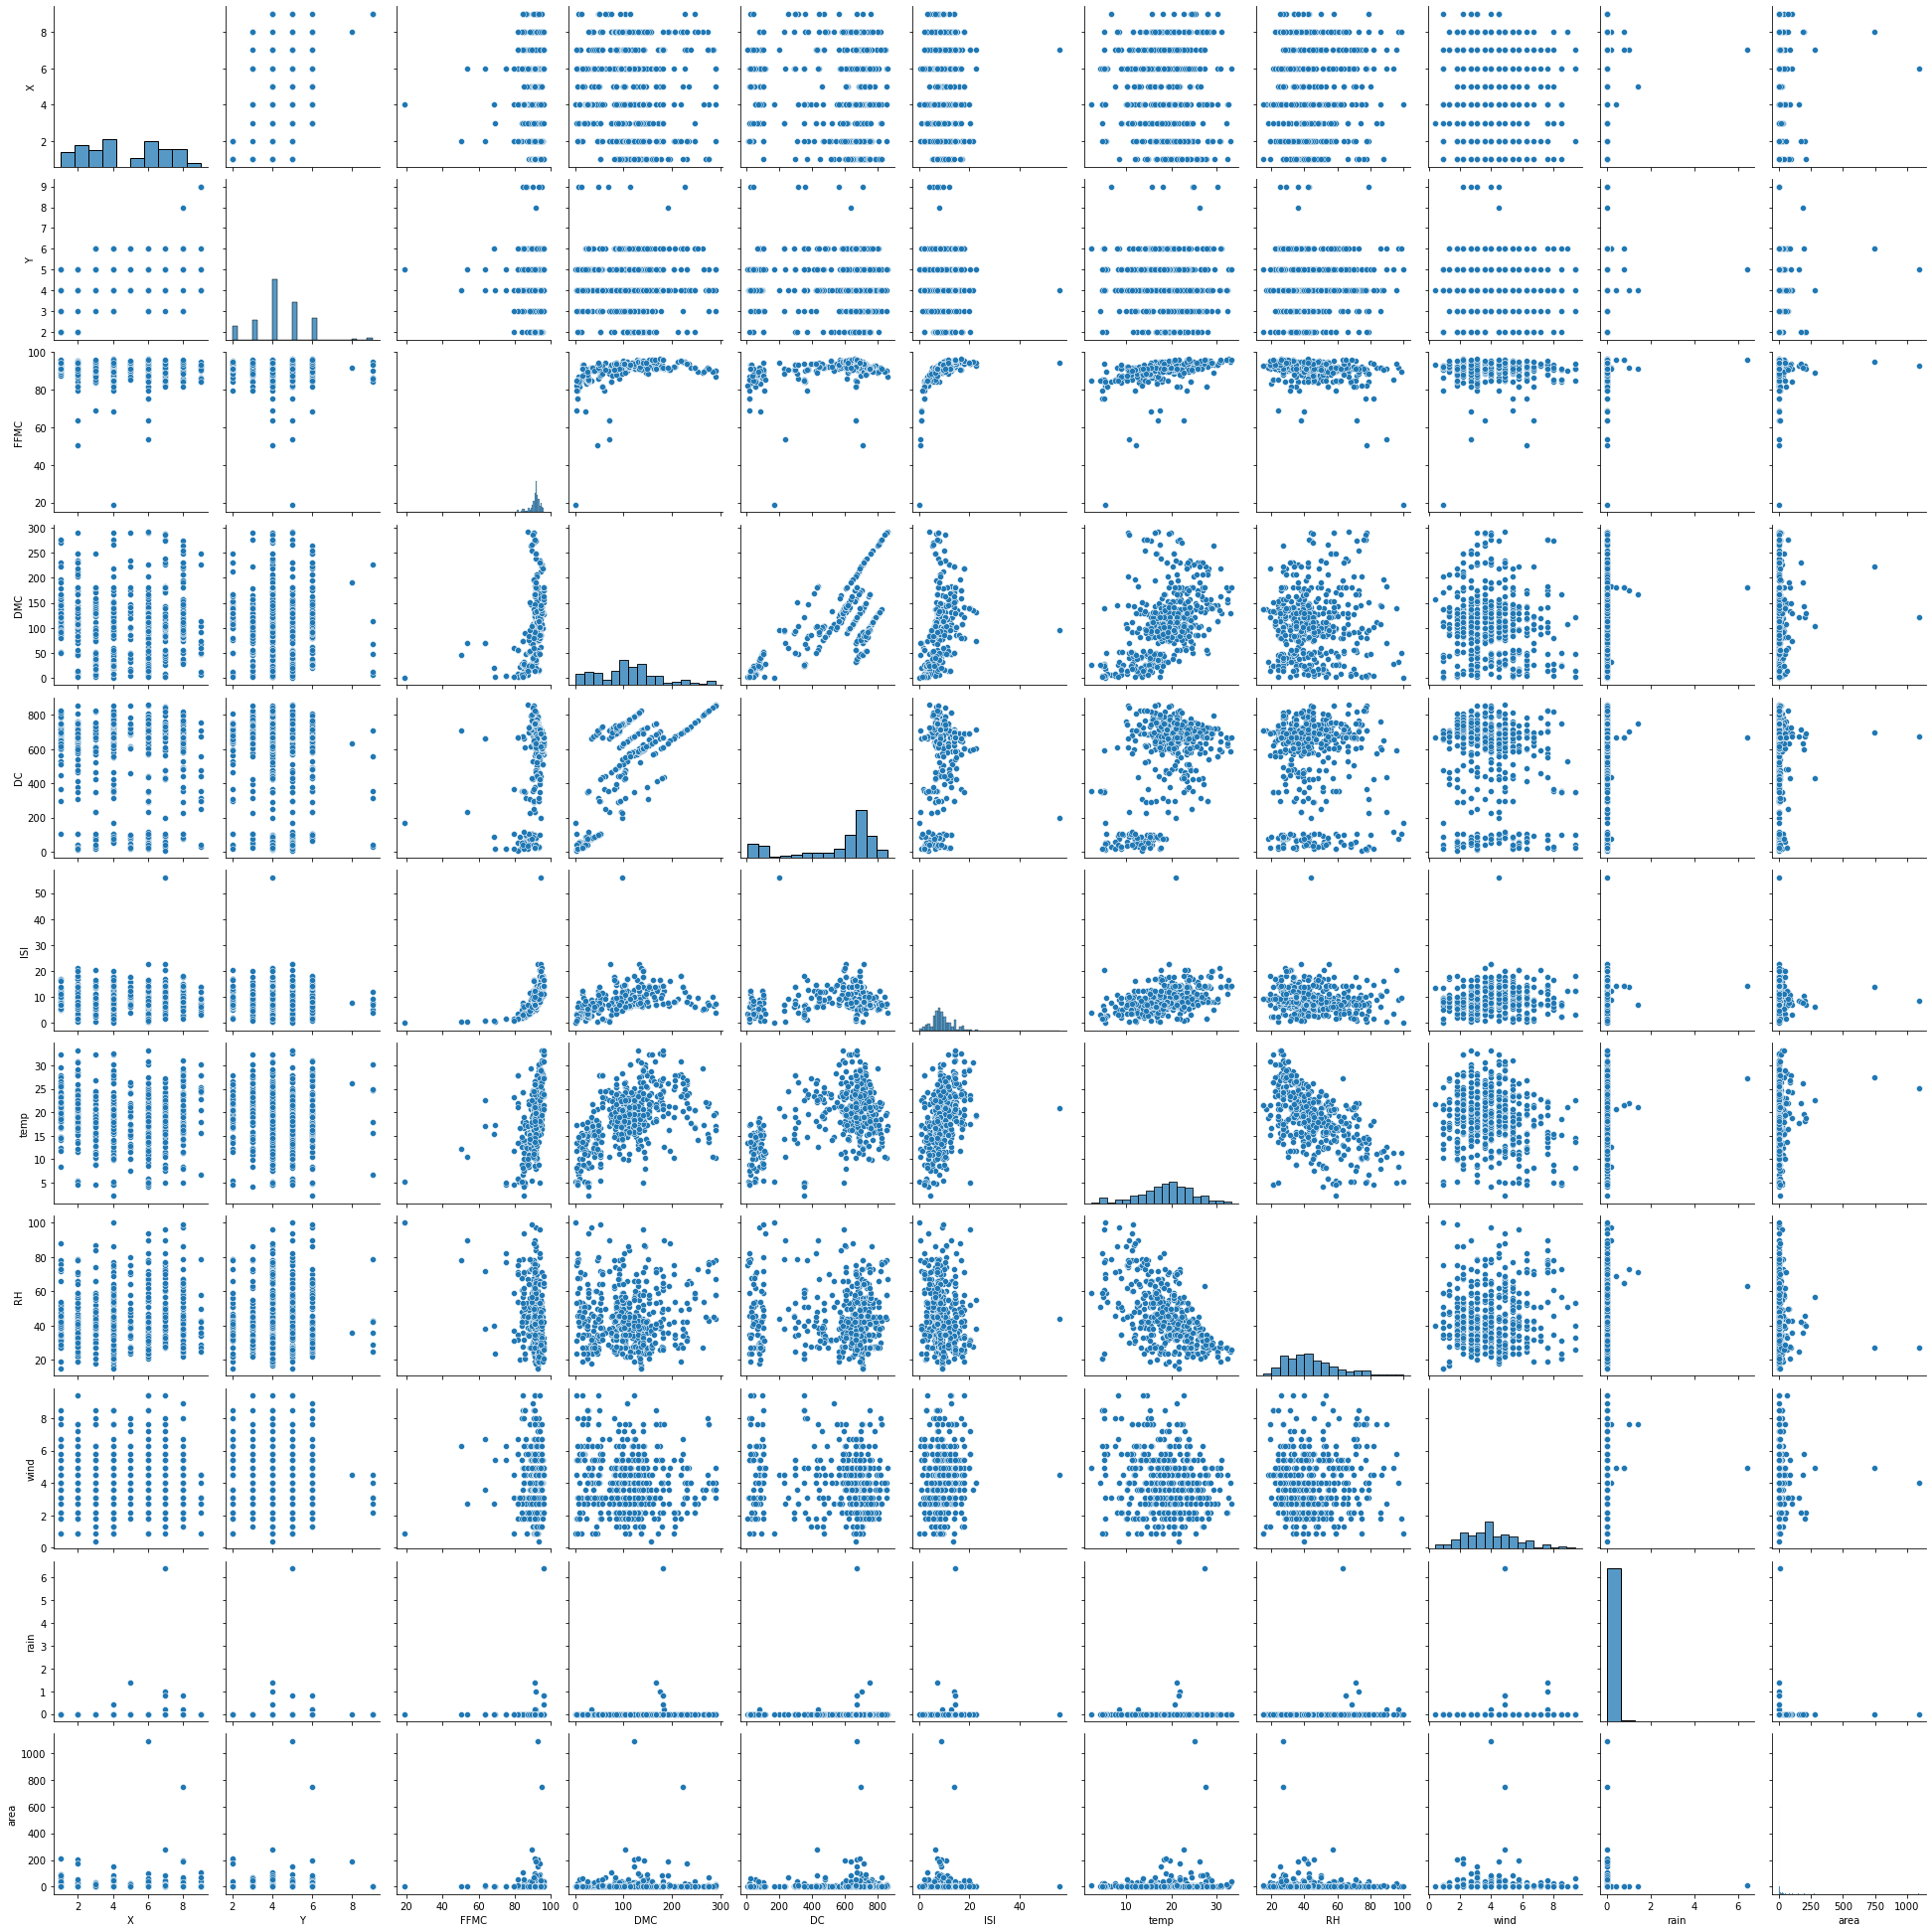

In [7]:
sns.pairplot(ForestFires_data)

Looking at the plot we can easily see that the data set contains plenty of possible outliers, with the most notables present in ```ISI``` and ```rain```. Since a good regression model should be resilient to outliers, I decided to not remove them. 

No evident relationship can be seen looking at the pair plot. 

Furthermore the burned area variable has quite a peculiar distribution. On one hand, the vast majority of observations are 0 forest hectares (ha), meaning that the burned area is lower than $ 100m^{2} $. On the other hand, there are only a few large fires, with an area in the order of thousands.     
This results in a distribution skewed to the left. To account for this distribution I decide to transform the area data by applying the $ ln(x + 1) $ as suggested by the article linked to this data set [Article: A Data Mining Approach to Predict Forest Fires using Meteorological Data](http://www3.dsi.uminho.pt/pcortez/fires.pdf)

In [31]:
ForestFires_data['area'] = ForestFires_data['area'].apply(lambda x: np.log(x + 1)) 
#I used a simple function (lambda functions) and applied it to each observation using .apply

To look for possible correlations between variables we can also use a correlation matrix.     
Having variables strictly correlated should guide us towards feature selection methods 
to obtain a simpler model that still performs well. 

<AxesSubplot:>

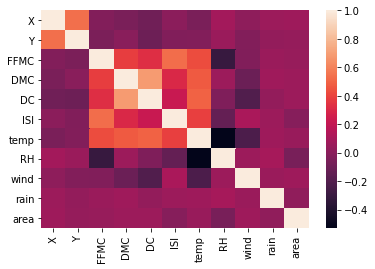

In [9]:
#Correlation matrix
sns.heatmap(ForestFires_data.corr())

Many variables show some degree of correlation, but as seen from the pair plot no variable show a high correlation with the logarithm of the area. 

### Chategorical variables
Months and days are categorical variables and we must taken them into account using dummy variables. This way we can develop a regression model taking into account also categorical variables. 

The best way to encode months and days into a dummy variable is through the use of One Hot encoding. 
This way each month and each day will have the same importance in a regression model. 

To perform One Hot encoding we can use the function defined during the lesson: ``` onehot_feature```

In [10]:
def onehot_feature(pd_data, column_name):
    col_values = pd_data[column_name].to_numpy().astype('<U')
    values, value_idx = np.unique(col_values, return_inverse=True)
    n_values = values.size
    onehots = np.eye(n_values, n_values)
    value_onehot = onehots[value_idx] 
    
    pd_data = pd_data.drop(column_name, axis=1)

    for i in range(n_values):
        pd_data["{}_{}".format(column_name, values[i])] = value_onehot[:, i]
        
    return pd_data

In [11]:
ForestFires_data = onehot_feature(ForestFires_data, 'month') 
ForestFires_data = onehot_feature(ForestFires_data, 'day') 

## Prepare the data to perform regression
First of all, we must separate the area variable from all the others, defining the output and the input variables of the regression model. 


We can split the data into a train and test set using ```train_test_split```. 

Splitting the data into a train set and a test set enables us to divide the training and the evaluation step of the model.     
Generally a 70 (train) / 30 (test) split can be used with good results.

Also, we can set a seed to make the random split reproducible. 

In [12]:
from sklearn.model_selection import train_test_split

X_all_features = [variable for variable in ForestFires_data if variable != 'area']

X = ForestFires_data[X_all_features].to_numpy()
y = ForestFires_data['area'].to_numpy()


X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.3, random_state = np.random.seed(40))
print("X_train.shape ", X_train.shape)
print("X_test.shape ", X_test.shape)


X_train.shape  (357, 29)
X_test.shape  (153, 29)


## Naive linear regression
Using ```sklearn``` we can perform many machine learning techniques. The most intuitive one is the use of a linear regression model to predict the burned area based on all the features. To evaluate the model we can use the ```mean_squared_error``` (MSE) function or also the ```r2_score``` (R2 score) function from sklearn. 

In [13]:
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error, r2_score


model = LinearRegression(fit_intercept=True)        
model.fit(X_train, y_train)
y_pred_train = model.predict(X_train)
y_pred_test = model.predict(X_test)


print("Train MSE:", mean_squared_error(y_train, y_pred_train))
print("Test MSE: ", mean_squared_error(y_test, y_pred_test))

print("Train R2 score:", r2_score(y_train, y_pred_train))
print("Test R2 score: ", r2_score(y_test, y_pred_test))


Train MSE: 1.695076535467649
Test MSE:  2.337716310722721
Train R2 score: 0.11998050208180688
Test R2 score:  -0.14527137520693478


Looking at the MSE and the R2 score we can see that the model performs sensibly better on the train set than on the test set. Also, the model has a negative R2 score on the test set!  Using all the input variables may not give optimal results.

## Hypothesis testing

To have an idea of which features might be meaningful to explaining the area of forest burned we can perform hypothesis testing using the t-test.    
The ```show_stats``` function seen during lecture implements the t-test in a userfriendly way. 

In [14]:
from scipy.stats import t, f

def show_stats(X, y, betas, names, alpha=None):
    n_samples, n_features = X.shape
    deg = n_samples-n_features
    
    if X.shape[1] + 1 == betas.shape[0]:
        X = np.concatenate([np.ones([X.shape[0], 1]), X], axis=-1)
    
    pred = X.dot(betas).reshape(-1)
    betas = betas.reshape(-1)
    y = y.reshape(-1)
    RSE = ((y-pred)**2).sum()/(n_samples - n_features)
    se2_b = RSE*(np.linalg.inv(np.dot(X.T, X)).diagonal())
    se_b = np.sqrt(se2_b)
    t_stat_b = (betas - 0) / se_b
    p_values = np.array([2*t.sf(np.abs(t_stat), deg) for t_stat in t_stat_b])
    
    df = pd.DataFrame()
    df["Name"] = names
    df["Coefficients"] = betas
    df["Standard Errors"] = se_b
    df["t-stat"] = t_stat_b
    df["p-value"] = p_values
    if alpha:
        rejectH0 = p_values < alpha
        df["reject H0"] = rejectH0    
    
    RSS = np.sum((y - pred)**2)
    MSE = RSS/y.shape[0]

    return df


betas = np.array([model.intercept_, *model.coef_]).reshape(-1, 1)
show_stats(X_train, y_train, betas, ['Intercept', *X_all_features], alpha=0.05)  


,Name,Coefficients,Standard Errors,t-stat,p-value,reject H0
0,Intercept,-1.166955,5.418045e+06,-2.153830e-07,1.000000,False
1,X,0.053588,3.800413e-02,1.410056e+00,0.159471,False
2,Y,0.026534,7.305557e-02,3.632095e-01,0.716682,False
3,FFMC,0.014695,1.709185e-02,8.597528e-01,0.390553,False
4,DMC,0.002453,2.310629e-03,1.061726e+00,0.289141,False
5,DC,-0.002224,1.670675e-03,-1.330919e+00,0.184140,False
6,ISI,-0.010698,1.978069e-02,-5.408297e-01,0.588992,False
7,temp,0.042184,2.718882e-02,1.551513e+00,0.121743,False
8,RH,0.007227,7.655468e-03,9.439683e-01,0.345881,False
9,wind,0.095893,4.444541e-02,2.157538e+00,0.031689,True


Using an alpha of 0.05 we can reject the null hypothesis only for wind (so wind seems meaningful).
Since we are performing a t-test on many variables (29!) the possibility of a false positive result is high, meaning that wind might be a spurious result. To take into consideration also the dimension of the dataset we can perform an F statistics. 

In [15]:
# Functions needed to perform the F statistics

# Residual Sum of Squares (rss)
def rss(y_true, y_pred):                    
    y_true = y_true.reshape(y_pred.shape)
    return np.sum((y_true - y_pred) ** 2)


# Total Sum of Squares
def tss(y): 
    return np.sum((y - y.mean()) ** 2)


 # Helper function that uses scikit-learn models
def multiple_least_squares(X, y, model = LinearRegression(fit_intercept=True)):
    model = model.fit(X,y)
    y_pred = model.predict(X)
    betas = [model.intercept_, *model.coef_]
    return betas, y_pred

In [16]:
# F statistics 
def Fstat(X, y, alpha = 0.05):
    
    betas_complete, y_pred = multiple_least_squares(X, y)

    n = X.shape[0]
    nf_complete = X.shape[1]

    # Compute RSS ans TSS
    rss_complete = rss(y, y_pred)
    tss_y = tss(y)

    # Compute the F statistics
    F_num = (tss_y - rss_complete) / nf_complete
    F_den = rss_complete / (n - nf_complete - 1)
    F = F_num / F_den

    # Compute the p-value
    alpha = 0.05
    p_value = f.sf(F, nf_complete, n - nf_complete - 1)

    print("F-stat: ", F)
    print("p-value: ", p_value)
    if p_value < alpha:
        print("Reject H0: At least one coefficient is different from 0")
    else:
        print("Accept H0: No evidence to say that at least one coefficient is different from 0")

    
Fstat(X_train, y_train)

F-stat:  1.5373336564020648
p-value:  0.04100973156521099
Reject H0: At least one coefficient is different from 0


With the confirmation of the F statistics we know that at least one of the features is meaningful at alpha 0.05, and being wind the only one for which we rejected the null hypothesis we can try to use it to perform a polynomial regression.

## ```Wind```:  hyperparameter tuning
At first, we can try to predict the burned area using a linear model that relays on a single feature, wind. 


In [17]:
X_features = ['wind']
X = ForestFires_data[X_features].to_numpy()

X_train_small, X_test_small, y_train_small, y_test_small = train_test_split(X, y,
                                                                test_size= 0.3, # keeping the same split
                                                                random_state= 40) # and seed

model = LinearRegression()                       # 1- hyperparams selection
model = model.fit(X_train_small, y_train_small)        # 2- model fitting
y_predict_test = model.predict(X_test_small)     # 3- prediction
y_predict_train = model.predict(X_train_small)


print("Train MSE score ", mean_squared_error(y_train, y_predict_train))
print("Test  MSE score ",  mean_squared_error(y_test, y_predict_test))


print("Train R2 score ", r2_score(y_train, y_predict_train))
print("Test  R2 score ",  r2_score(y_test, y_predict_test))


Train MSE score  1.9068633782877589
Test  MSE score  2.060657386004516
Train R2 score  0.010028799498174812
Test  R2 score  -0.009537345260728136


As for the previous model, the test scores are quite unsatisfactory but a small improvement can be seen in the MSE and R2 score. 

At this point we can try to find the best possible degree for the polynomial function of wind trough hyperparameter selection. A hyperparameter is a parameter we cannot directly optimize with the training algorithm. For this task we can rely on different methods (e.x. : hold-out, cross-validation and grid search). We can compare cross-validation to grid-search.

### Cross-Validation
Cross-validation is used to robustly estimate the performance of a model. Using the train set we simulate to have multiple training and validation sets, called folds.  Than we iteratively reserve a part of the training set for validation and train the model on the remaining data. The validation score is the average score on all the validation sets. In the end we pick the model with the best validation score. 

An important consideration is that parameter selection is bound  to how  general our validation set is, especially if the training / validation set is small! 

In [33]:
from sklearn.preprocessing import PolynomialFeatures
from sklearn.pipeline import Pipeline
from sklearn.model_selection import cross_val_score
from sklearn.metrics import make_scorer


r2_scorer = make_scorer(r2_score,
                        greater_is_better=True)

degree = list(range(1,6))
val_scores = np.zeros(len(degree))

# Validation
for i, d in enumerate(degree):
    model = Pipeline([('poly', PolynomialFeatures(degree=d, include_bias=False)),
                      ('linear', LinearRegression(fit_intercept=True))])
    scores = cross_val_score(model, X_train_small, y_train_small, scoring=r2_scorer, cv=5)  
    val_scores[i] = np.mean(scores)

# Identifies which is the best degree
best_model_idx = np.argmax(val_scores)
best_degree = degree[best_model_idx]
# And the corresponding (best) validation score
best_val_score = val_scores[best_model_idx]
print("Best degree: ", best_degree,
      "\nVal score: ", best_val_score)
    
    
# Train again the Pipeline using the best parameter and the whole training set
model = Pipeline([('poly', PolynomialFeatures(degree=best_degree, include_bias=False)),
                  ('linear', LinearRegression(fit_intercept=True))])
# Note: we train on X_train_small + X_val
model = model.fit(np.concatenate([X_train_small]), np.concatenate([y_train_small]))
y_predict = model.predict(X_test_small)
test_score = r2_score(y_test_small, y_predict)

print("Test R2 score:", test_score)


Best degree:  1 
Val score:  0.025418717329511398
Test R2 score: -0.10376010816216996


### Grid-search
GridSearch performs cross-validation while also searching among a set of different hyperparameters. We expect the same result.

In [19]:
from sklearn.model_selection import GridSearchCV

# Validation
model = Pipeline([('poly', PolynomialFeatures(degree=1, include_bias=False)),
                  ('linear', LinearRegression(fit_intercept=True))])

# Select parameters to optimize
parameters = {'poly__degree': list(range(1,6))}
              #'linear__fit_intercept': [True, False],
              #'linear__normalize': [True, False]}

cv = GridSearchCV(model, parameters, scoring=r2_scorer, cv=5, refit=True)
cv.fit(X_train_small, y_train_small)

pd.DataFrame(cv.cv_results_)

,mean_fit_time,std_fit_time,mean_score_time,std_score_time,param_poly__degree,params,split0_test_score,split1_test_score,split2_test_score,split3_test_score,split4_test_score,mean_test_score,std_test_score,rank_test_score
0,0.000967,0.000138,0.000344,0.000075,1,{'poly__degree': 1},-0.026628,0.012033,-0.023356,0.024169,-0.011255,-0.005007,0.019924,1
1,0.000976,0.000298,0.000325,0.000108,2,{'poly__degree': 2},-0.031893,-0.002883,-0.041627,0.023460,-0.009881,-0.012565,0.022878,2
2,0.001505,0.000313,0.000299,0.000057,3,{'poly__degree': 3},-0.027603,-0.024263,-0.035031,0.015034,-0.004849,-0.015343,0.018168,3
3,0.001615,0.000304,0.000338,0.000062,4,{'poly__degree': 4},-0.034715,-0.047372,-0.038120,-0.010586,-0.006001,-0.027359,0.016174,4
4,0.002063,0.000536,0.000358,0.000106,5,{'poly__degree': 5},-0.044629,-0.046035,-0.046006,-0.015700,-0.006711,-0.031816,0.017074,5


The output of ```GridSearchCV``` is a summary table that also specifies the best models. As we can see the best model is still the first-degree polynomial regression of wind. 


## Feature Selection
To perform feature selection we could try Best Feature Subset Selection, 
but given the high number of variables, it would take days if not more, to evaluate all the possible models.
Of course, it is not advisable, but just to have an idea of how much time it would be needed I tried to perform Best Feature Subset Selection for 12h. 

### Best Feature Subset Selection

In [1]:
from sklearn.dummy import DummyRegressor

def subset_selection(Xtrain_pd, ytrain, Xtest_pd, ytest,
                     candidates_evaluator, candidates_argbest, # Metric to be used at 2.b
                     subsets_evaluator, subsets_argbest,       # Metric to be used at 3
                     test_evaluator=None, test_argbest=None, # Metric to be used on the test set
                     candidates_scorer_name=None,  # Name of 2. figure
                     subsets_scorer_name=None,     # Name of 3. figure
                     verbose=True, weight_step3=0):  
    test_evaluator = subsets_evaluator if not test_evaluator else test_evaluator
    test_argbest = subsets_argbest if not test_argbest else test_argbest
    
    # Global variable init
    # ====================
    num_features = Xtrain_pd.shape[-1]
    best_candidate_metric = []
    # subsets_* are lists containing one value for each Mk model (the best of the Mk candidates)
    subsets_test = [] 
    subsets_metric = []        # The best metric of each subset of dimension 'dim'
    subsets_best_features = [] # The best features combination in each subset of dimension 'dim'
    # A figure to keep track of candidates scores in each Mk subset
    plt.figure()
    num_evaluations = 0        # A counter to keep track of the total number of trials
    
    # 1. and 2. Evaluate all Mk candidates with
    #           k=0...P features
    # =========================================
    for dim in range(num_features+1):
        candidate_metrics = [] # Keep track of candidates metrics. Will be used to select the best
        candidate_models = []  # Keep track of candidates trained models
        
        # 2.a Fixed the number of features 'dim', look at
        #     all the possible candidate models with that
        #     cardinality
        # ===============================================
        dim_subsets = get_subsets(Xtrain_pd, dim=dim)
        for Xtrain_sub in dim_subsets:
            
            # Train the model on the subset
            if Xtrain_sub.shape[-1] == 0:
                # 1. Train the M0 model if the number of
                #    features is zero!
                # ======================================
                model = DummyRegressor()
            else:
                model = LinearRegression(fit_intercept=True)
            
            model, score = candidates_evaluator(model, Xtrain_sub, ytrain)
            candidate_models.append(model)
            candidate_metrics.append(score)
            num_evaluations += 1
            
        _ = candidate_fig.scatter([dim]*len(candidate_metrics), candidate_metrics,
                                  color="b")
            
        # 2.b Select the best candidate among those using
        #     the same number of features (2.a)
        # ===============================================
        idx_best_candidate = candidates_argbest(candidate_metrics)
        # Save best candidate features
        best_features = dim_subsets[idx_best_candidate].columns.tolist()
        best_candidate_metric.append(candidate_metrics[idx_best_candidate])
        subsets_best_features.append(best_features)
        
        # Compute metric for step 3.
        best_subset_model = candidate_models[idx_best_candidate]
        best_subset_Xtrain = dim_subsets[idx_best_candidate]
        _, score = subsets_evaluator(best_subset_model, best_subset_Xtrain, ytrain, trained=True)
        subsets_metric.append(score)
        best_subset_Xtest = Xtest_pd[best_subset_Xtrain.columns.tolist()]
        _, score = test_evaluator(best_subset_model, best_subset_Xtest, ytest, trained=True)
        subsets_test.append(score)
        num_evaluations += weight_step3
        
        if verbose:
            print("............")
            print("Best model (M{}) with {} features: {}".format(dim, dim, best_features))
            print("M{} subset score (3.): {}".format(dim, score))
        
    # 3. Among all best candidates with increasing number
    #    of features, select the best one
    # ===================================================
    best_subset_idx = subsets_argbest(subsets_metric)
    best_features = subsets_best_features[best_subset_idx]
    
    if verbose:
        print("\n\nBest configuration has {} features".format(best_subset_idx))
        print("Features: {}".format(subsets_best_features[best_subset_idx]))
        print("Total number of trained models:", num_evaluations)


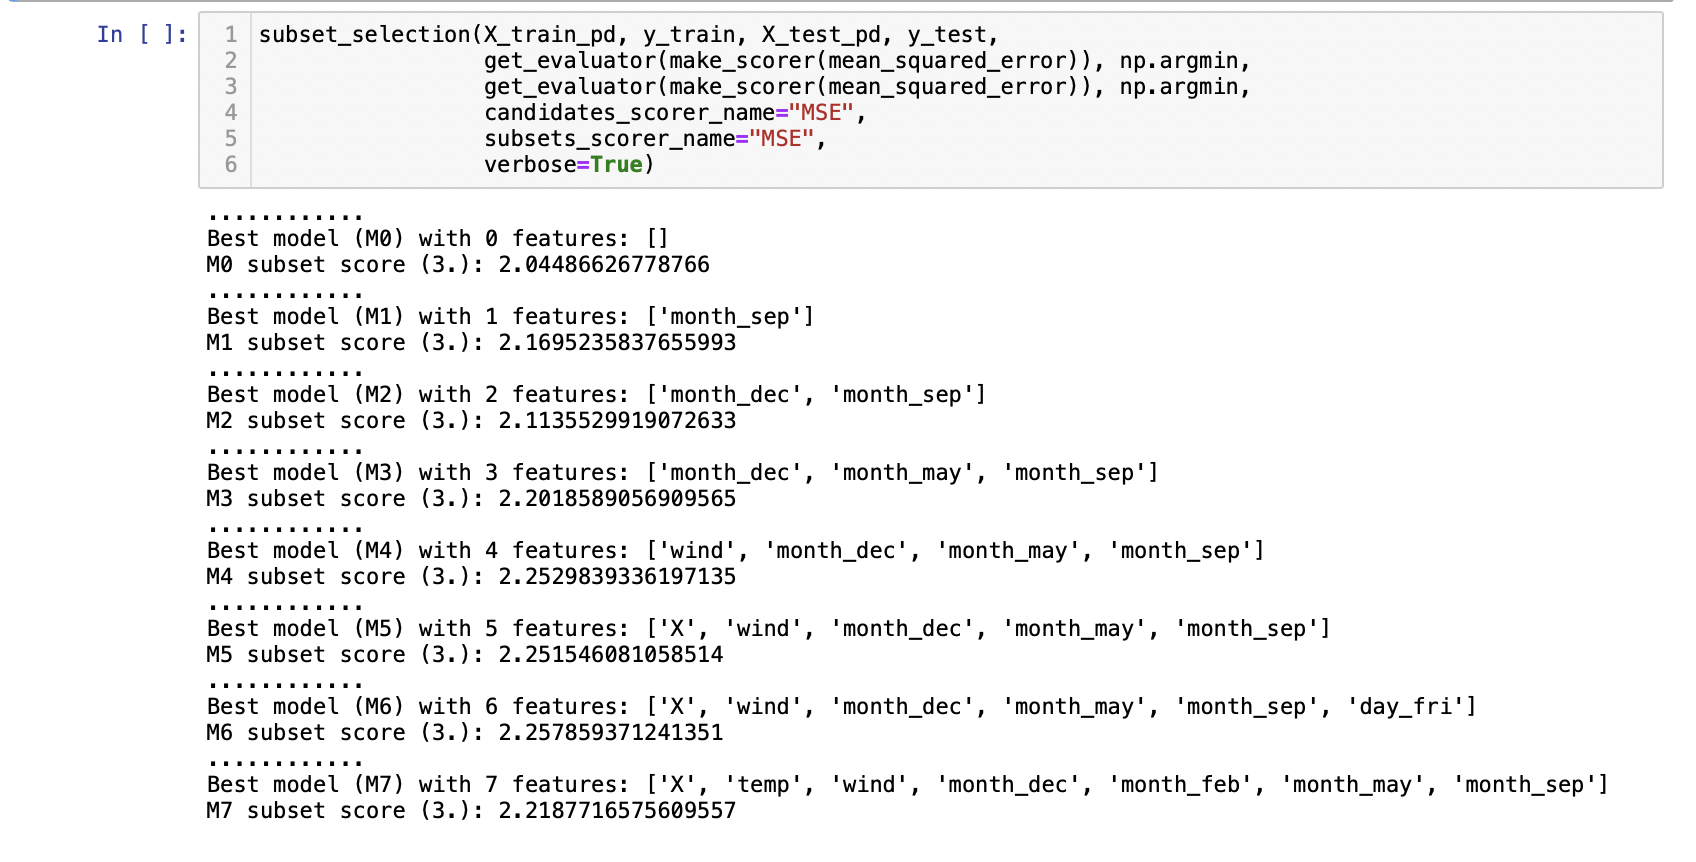

After 12 hours of work, I only managed to get the best possible subsets with at most 7 variables. Interestingly this result will come in handy for a comparison with other types of feature selection algorithms. 

## Forward Selection
Forward selection is a greedy approach used to finding an optimal subset of features without the heavy time cost of the best feature possible subset. 

In [21]:
from sklearn.dummy import DummyRegressor

def forward_selection(Xtrain_pd, ytrain, Xtest_pd, ytest,
                      candidates_evaluator, candidates_argbest, # Metric to be used at 2.b
                      subsets_evaluator, subsets_argbest,       # Metric to be used at 3
                      test_evaluator=None, test_argbest=None,
                      candidates_scorer_name=None,  # Name of 2. figure
                      subsets_scorer_name=None,     # Name of 3. figure
                      verbose=True, weight_step3=0):   
    test_evaluator = subsets_evaluator if not test_evaluator else test_evaluator
    test_argbest = subsets_argbest if not test_argbest else test_argbest
    
    # Global variable init
    # ====================
    num_features = Xtrain_pd.shape[-1]
    best_candidate_metric = []
    # subsets_* are lists containing one value for each Mk model (the best of the Mk candidates)
    subsets_test = []
    subsets_metric = []        # The best metric of each subset of dimension 'dim'
    subsets_best_features = [] # The best features combination in each subset of dimension 'dim'
    num_evaluations = 0        # A conter to keep track of the total number of trials
    
    selected_features = []  # <------ !! We keep track of selected features !!
    all_features = Xtrain_pd.columns
    
    
    # 1. Train M0
    # ===========
    model = DummyRegressor()
    # Compute (2.b) metrics
    model, score = candidates_evaluator(model, Xtrain_pd[[]], ytrain)
    best_candidate_metric.append(score)
    subsets_best_features.append([])
    # Compute metric for step 3.
    _, score = subsets_evaluator(model, Xtrain_pd[[]], ytrain, trained=True)
    subsets_metric.append(score)
    _, score = test_evaluator(model, Xtrain_pd[[]], ytrain, trained=True)
    subsets_test.append(score)
    
    # 2. Evaluate all Mk candidates with
    #    k=0...P features
    # =========================================
    #!! The loop condition is slightly changed
    #!! How many iterations we need to perform?
    for dim in range(num_features):
        candidate_metrics = [] # Keep track of candidates metrics. Will be used to select the best
        candidate_models = []  # Keep track of candidates trained models
        
        # 2.a Given the previous Mk model, test remaining
        # features and select the one providing the best
        # performance increment
        # ===============================================
        remaining_features = Xtrain_pd.columns.difference(selected_features)
        
        for new_column in remaining_features:
            Xtrain_sub = Xtrain_pd[selected_features + [new_column]].to_numpy()
            model = LinearRegression(fit_intercept=True)
            model, score = candidates_evaluator(model, Xtrain_sub, ytrain)
            candidate_models.append(model)
            candidate_metrics.append(score)
            num_evaluations += 1
            
            
        # 2.b Select the best candidate in (2.a)
        # ===============================================
        idx_best_candidate = candidates_argbest(candidate_metrics)
        #!!! Update selected feature
        # ==========================
        selected_features.append(remaining_features[idx_best_candidate])
        # Save best candidate features
        best_candidate_metric.append(candidate_metrics[idx_best_candidate])
        best_features = selected_features.copy()
        subsets_best_features.append(best_features)
        
        # Compute metric for step 3.
        best_subset_model = candidate_models[idx_best_candidate]
        best_subset_Xtrain = Xtrain_pd[best_features].to_numpy()
        _, score = subsets_evaluator(best_subset_model, best_subset_Xtrain, ytrain, trained=True)
        subsets_metric.append(score)
        best_subset_Xtest = Xtest_pd[best_features].to_numpy()
        _, score = test_evaluator(best_subset_model, best_subset_Xtest, ytest, trained=True)
        subsets_test.append(score)
        num_evaluations += weight_step3 
        
        if verbose:
            print("............")
            print("Best model (M{}) with {} features: {}".format(dim, dim + 1, best_features)) # dim +1!
            print("M{} subset score (3.): {}".format(dim, score))
        
    # 3. Among all best candidates with increasing number
    #    of features, select the best one
    # ===================================================
    best_subset_idx = subsets_argbest(subsets_metric)
    best_features = subsets_best_features[best_subset_idx]
    
    if verbose:
        print("\n\nBest configuration has {} features".format(best_subset_idx))
        print("Features: {}".format(subsets_best_features[best_subset_idx]))
        print("Total number of trained models:", num_evaluations)


 Furthermore, we need to implement an evaluator function to train the model and evaluate it against a particular training set.      
 ``` get_evaluator``` is a function that, given a scorer, generates the evaluator function that uses that scorer to evaluate the model. Also other helping functions (```get_subsets```, ```estimate_sigma```, ```get_sigma_scorer```, ```get_evaluator``` and ```bic```) are needed to implement greedy feature selection approaches like forward selection. 


In [22]:
from sklearn.dummy import DummyRegressor
import itertools

def get_subsets(X_pd, dim):
    feature_names = X_pd.columns.tolist()
    # Compute all possibile combinations of 'dim' values
    subset_names = itertools.combinations(feature_names, dim) # list of list of names [[name of first candidate, ...], [...]]
    # Convert names into datasets
    data_subsets = [X_pd[list(fnames)] for fnames in subset_names]
    return data_subsets
  
    
    
def estimate_sigma(Xtrain_pd, ytrain):
    # Sigma is usually estimated using the model with all features
    n, p = Xtrain_pd.shape
    model = LinearRegression(fit_intercept=True)
    model.fit(Xtrain_pd, ytrain)
    y_pred = model.predict(Xtrain_pd)
    RSS = rss(y_pred, ytrain)
    RSE = np.sqrt(RSS / (n-p))
    return RSE



def get_sigma_scorer(metric, sigma):
    def scorer(model, X, y):
        n, d = X.shape
        y_pred = model.predict(X)
        return metric(y_pred, y, n, d, sigma)
    
    return scorer



def get_evaluator(scorer):
    def evaluator(model, X, y, trained=False):
        if not trained:
            model = model.fit(X, y)
        score = scorer(model, X, y)
        return model, score
    return evaluator    




def bic(y_pred, y_true, n, d, sigma):
    sigma2 = sigma**2
    return (rss(y_pred, y_true) + np.log(n)*d*sigma2) / (n*sigma2)

Now we can perform forward selection using the R2 score to select the best model concerning a given number of features and then the Bayesian Information Criterion (BIC) to pick the best model among the selected ones. 

In [23]:
X_train_pd = pd.DataFrame(X_train, columns=X_all_features)
X_test_pd = pd.DataFrame(X_test, columns=X_all_features)

sigma = estimate_sigma(X_train_pd, y_train)

forward_selection(X_train_pd, y_train, X_test_pd, y_test,
                  get_evaluator(make_scorer(r2_score)), np.argmax, # 2.
                  get_evaluator(get_sigma_scorer(bic, sigma)), np.argmin, # 3.
                  get_evaluator(make_scorer(mean_squared_error)), np.argmin, # test
                  candidates_scorer_name="R^2",
                  subsets_scorer_name="BIC",
                  verbose=True)

............
Best model (M0) with 1 features: ['month_sep']
M0 subset score (3.): 2.1695235837655993
............
Best model (M1) with 2 features: ['month_sep', 'month_dec']
M1 subset score (3.): 2.1135529919072633
............
Best model (M2) with 3 features: ['month_sep', 'month_dec', 'month_may']
M2 subset score (3.): 2.201858905690957
............
Best model (M3) with 4 features: ['month_sep', 'month_dec', 'month_may', 'wind']
M3 subset score (3.): 2.252983933619714
............
Best model (M4) with 5 features: ['month_sep', 'month_dec', 'month_may', 'wind', 'X']
M4 subset score (3.): 2.251546081058514
............
Best model (M5) with 6 features: ['month_sep', 'month_dec', 'month_may', 'wind', 'X', 'day_fri']
M5 subset score (3.): 2.257859371241351
............
Best model (M6) with 7 features: ['month_sep', 'month_dec', 'month_may', 'wind', 'X', 'day_fri', 'month_feb']
M6 subset score (3.): 2.2948790336126286
............
Best model (M7) with 8 features: ['month_sep', 'month_dec',

We trained only 435 models and we selected for the best configuration a model with only two features, the month of September and December. Looking back at the best possible subset results we can see that the results match a model of only 2 features. 

We can also try using Cross-Validation to pick the best model configuration for a particular number of features and again Cross-Validation to pick the best possible models. This way we obtain a more robust model in exchange for a higher computational cost. 

## Forward selection using Cross-Validation

In [24]:
def get_val_evaluator(scorer, val_size=0.3):
    def evaluator(model, X, y, trained=False):
        X_train_small, X_val, y_train_small, y_val = train_test_split(X, y, 
                                                                      test_size=val_size,
                                                                      random_state=40 )
        
        if not trained:
            model = model.fit(X_train_small, y_train_small)
        score = scorer(model, X_val, y_val) 
        
        return model, score
    
    return evaluator

def get_cv_evaluator(scorer, cv=3):
    def evaluator(model, X, y, trained=False):            
        scores = cross_val_score(model, X, y, scoring=scorer, cv=cv)
        if not trained:
            model = model.fit(X, y)
        return model, np.mean(scores)
    
    return evaluator


cv = 10
sigma = estimate_sigma(X_train_pd, y_train)
forward_selection(X_train_pd, y_train, X_test_pd, y_test,
                  get_evaluator(make_scorer(r2_score)), np.argmax, # 2.b
                  # Use either 5-fold CV or (1-fold cross) validation to 
                  # estimate the test R^2 error at step (3.) of the algorithm
                  get_cv_evaluator(make_scorer(r2_score), cv = cv), np.argmax, # 3.
                  get_evaluator(make_scorer(r2_score)), np.argmax, # test
                  candidates_scorer_name="cv(R^2)",
                  subsets_scorer_name="cv(R^2)",
                  verbose=True, weight_step3=10)

............
Best model (M0) with 1 features: ['month_sep']
M0 subset score (3.): -0.06287202040992956
............
Best model (M1) with 2 features: ['month_sep', 'month_dec']
M1 subset score (3.): -0.03545144913927567
............
Best model (M2) with 3 features: ['month_sep', 'month_dec', 'month_may']
M2 subset score (3.): -0.07871342872767584
............
Best model (M3) with 4 features: ['month_sep', 'month_dec', 'month_may', 'wind']
M3 subset score (3.): -0.10376010816216996
............
Best model (M4) with 5 features: ['month_sep', 'month_dec', 'month_may', 'wind', 'X']
M4 subset score (3.): -0.10305568933574638
............
Best model (M5) with 6 features: ['month_sep', 'month_dec', 'month_may', 'wind', 'X', 'day_fri']
M5 subset score (3.): -0.1061486354287402
............
Best model (M6) with 7 features: ['month_sep', 'month_dec', 'month_may', 'wind', 'X', 'day_fri', 'month_feb']
M6 subset score (3.): -0.12428495053215083
............
Best model (M7) with 8 features: ['month_s

Once again the best suggested configuration has 4 features that match perfectly the ones of the best possible subset of a model of 4 features. So we can try to predict the burned area using only those 4 features.

In [25]:
X_features = ['month_sep', 'month_dec', 'month_may', 'wind']
X = ForestFires_data[X_features].to_numpy()

X_train_small, X_test_small, y_train_small, y_test_small = train_test_split(X, y,
                                                                test_size= 0.3, # keeping the same split
                                                                random_state= 40) # and seed

model = LinearRegression()                       # 1- hyperparams selection
model = model.fit(X_train_small, y_train_small)        # 2- model fitting
y_predict_test = model.predict(X_test_small)     # 3- prediction
y_predict_train = model.predict(X_train_small)


print("Train MSE score ", mean_squared_error(y_train, y_predict_train))
print("Test  MSE score ",  mean_squared_error(y_test, y_predict_test))


print("Train R2 score ", r2_score(y_train, y_predict_train))
print("Test  R2 score ",  r2_score(y_test, y_predict_test))

Train MSE score  1.7958807901996163
Test  MSE score  2.252983933619714
Train R2 score  0.06764675326215863
Test  R2 score  -0.10376010816216996


Looking at the results we do not have a good regression model given that the test results present only a slight improvement from the naive model. 

## LASSO 
Another method to perform feature selection is the Least Absolute Shrinkage and Selection Operator (LASSO). With LASSO we first need to standardize the parameters and then apply a penalty to the linear regression function to tune the parameters of the model. Eventually, with a high enough penalty, all the features will be shrunk to zero, effectively eliminating them. In this sense, LASSO can be employed as a tool for feature selection.  This is also the main difference with other methods used for shrinking the parameters (like Ridge Regression) because those methods do not remove parameters but only shrink them.

Using sklearn we can easily implement LASSO with ```linear_model.Lasso``` and see how the features behave for a given range of alphas. This way we can retrieve the most meaningful features, i.e the last ones that go to zero. 

/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 7.111950106878794, tolerance: 0.06876464948714178
  model = cd_fast.enet_coordinate_descent(


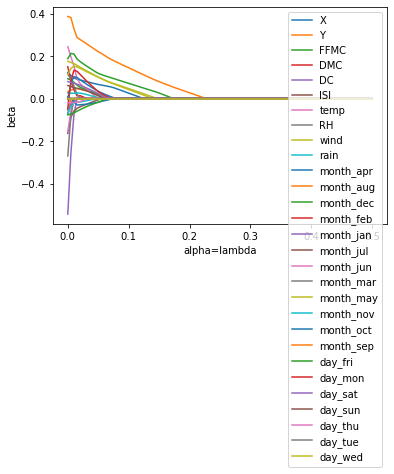

In [26]:
# LASSO
from sklearn import linear_model

alpha_vals = np.linspace(1e-4, 0.5, 100)
betas = []
first_to_zero = []

from sklearn import preprocessing
X_std = preprocessing.scale(X_train)

for alphas in alpha_vals:
    model = linear_model.Lasso(alpha = alphas)
    model.fit(X_std, y_train)
    beta = model.coef_.reshape(-1)
    #beta = (beta - beta.min()) / beta.ptp()
    betas.append(beta)
    first_to_zero.append(np.where( beta != 0)[0])               # <-------------- needed for the function           
betas = np.stack(betas, axis=1)  # [N_feat, N_Alpha_vals]       #                 get_lasso

for beta, name in zip(betas, X_all_features):
    plt.plot(alpha_vals, beta, label=name)
plt.legend()
plt.xlabel("alpha=lambda")
plt.ylabel("beta")

array_list = [array for array in first_to_zero if 0 not in array.shape]     # <---- needed for get_lasso

Looking at the graph we can see the behavior of all the 29 features in a range of alphas from 0 up to 0.5. Interestingly many features go quite quickly to zero, while only a few are not removed so easily. Unluckily, having 29 different variables may confuse given the color used in the graph. So I implemented a simple function (```get_Lasso```)  to retrieve the N most meaningful features. The result of the function is ordered from left to right, with the most meaningful features being on the far right. 


In [27]:
# get_Lasso relies on 2 lines present in the for cycle used to perform LASSO
# For each alpha we know the coefficient of each feature, 
# using that information we can select the non zero features. 

def get_Lasso(num_features = 5):
    len_old_list = 0
    for i in range(len(array_list)):    #defined in the previous chunck 
        new_list = []
        for idx in range(array_list[i].shape[0]):
            new_list.append(X_all_features[array_list[i][idx]])
        if len(new_list) == len_old_list: 
            pass
        elif (len(new_list) == num_features) or (len(new_list) < num_features):
            print(new_list)
            break
        else:
            pass
        len_old_list = len(new_list)

In [28]:
get_Lasso(4) 

['wind', 'month_dec', 'month_may', 'month_sep']


Also using LASSO we have the same features selected by the Best possibile subset of 4 features. 

## LASSO with Cross-Validation
Using sklearn we can also perform LASSO coupled with Cross-Validation.

In [29]:
# LASSO CV
X_std = preprocessing.scale(X_train)

model = linear_model.LassoCV(eps = 1e-4, n_alphas = 100, fit_intercept= True, cv = 5)
model.fit(X_std, y_train)

y_pred_train = model.predict(X_train)
y_pred_test = model.predict(X_test)

print("Best aplha using Cross-Validation:", model.alpha_)


Best aplha using Cross-Validation: 0.0895913468826856


```linear_model.LassoCV``` has the attribute ```aplha_``` that retrieves the best penalty given by Cross_Validation. Looking at the previous graph we can see that an alpha of 0.089 is able to shrink almost all the parameters to zero, retaining only the most impactful ones. 

In [30]:
print("Train MSE:", mean_squared_error(y_train, y_pred_train))
print("Test MSE: ", mean_squared_error(y_test, y_pred_test))

print("Train R2 score:", r2_score(y_train, y_pred_train))
print("Test R2 score: ", r2_score(y_test, y_pred_test))

Train MSE: 2.0628933086911103
Test MSE:  2.232406942846511
Train R2 score: -0.07097602721065921
Test R2 score:  -0.09367922776947535


Considering the MSE and R2 scores of the model based on LASSO Cross-Validation we can see a modest improvement in both MSE and R2 scores. Even though the R2 score is still negative!  

## Conclusions
Predicting the burned area of forest fires given meteorological data is a challenging task that requires a deep understanding of many advanced machine learning techniques. The focus of this project was to investigate possible relationships between the variables and to use that information to predict the burned area of the forest.  Using a naive model as a reference and performing different feature selection approaches and statistical tests lead to no significant improvement in the prediction power of the model. Also the feature selected by all the approaches, except for statistical testing, were not informative and so provided little to no insights into the problem. 

As suggested by the article, this problem requires more advanced methods (like Support Vector Machine SVM) that still may not be useful to understand the relationship between the variables. 

Furthermore, this data set presents many difficulties, first and foremost a high number of outliers. In addition, the output that we need to predict is, with very few exceptions, 0.  Subset strategies, feature engineering or outliers removal may lead to better results if performed correctly.

Last but not least, changing the seed for the split of the data into train and test should not lead to such high variability in the results of both statistical and scoring techniques. Once again proving the high variability of the data set. 